# LangGraph - Agent: Reasoning and Acting (ReAct) Agent
The main objective of the current project is to create a robust ReAct Agent that uses <b>Tools</b>.

https://www.youtube.com/watch?v=jGg_1h0qzaM

## Import Libraries

In [1]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from transformers import pipeline, logging
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain_core.messages import BaseMessage    # the functional class for all message types in langgraph
from langchain_core.messages import ToolMessage    # passes data back to LLM after it calls
from langchain_core.messages import SystemMessage  # message for providing instructions to the LLM
from langchain_core.tools import tool
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

logging.set_verbosity_error()

## Load Environment

In [2]:
load_dotenv("env.env")

True

## Create AgentState

In [3]:
class AgentState(TypedDict):
    # Annotated needs metadata; add_messages provides the metadate
    # Sequence[BaseMessage] is the type of data
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Create Tool

In [4]:
@tool
def add(a: int, b: int) -> int:
    """This is an addition function that adds two numbers together"""
    
    return a + b

In [5]:
# to infuse tools to LLM
tools = [add]

## LLM

In [6]:
# model_name = "microsoft/DialoGPT-medium"
# model_name = "gpt2"
model_name = "Qwen/Qwen2.5-7B-Instruct"
# model_name = "meta-llama/Llama-3-13b-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype='auto'
)

generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512
)

# # llm = ChatOpenAI(model="gpt-4o").bind_tools(tools)
# # bind_tools does not work for HuggingFace; better to create a tool node
llm_model = HuggingFacePipeline(pipeline=generator)
llm = ChatHuggingFace(llm=llm_model).bind_tools(tools)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Define Node

In [7]:
def model_call(state: AgentState) -> AgentState:
    """Passes a system prompt along with the query to the LLM"""

    # system_prompt = SystemMessage(
    #     content="You are my AI assitant, please answer my query to the best of your ability."
    # )
    system_prompt = SystemMessage(
        content="You are an AI assistant with access to the following tools:\n"
                "Always use tools when applicable and respond using ToolMessage objects.\n"
                "Please answer my query using the defined tool, called add."
    )
    
    response = llm.invoke([system_prompt] + state["messages"])

    return {"messages": [response]}

In [8]:
def check_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    
    if not last_message.tool_calls:
        return "end"
        
    return "continue"
    # if isinstance(last_message, AIMessage) and getattr(last_message, "tool_calls", None):
    #     return "continue"
        
    # return "end"

## Build Graph

In [9]:
# initialize
graph = StateGraph(AgentState)

# add node
graph.add_node("agent", model_call)

tool_node = ToolNode(tools=tools)
graph.add_node("tool", tool_node)

# add edges
graph.add_edge(START, "agent")
graph.add_conditional_edges(
    "agent",
    check_continue,
    {
        # format -> Edge: Node
        "continue": "tool",
        "end": END
    }
)
graph.add_edge("tool", "agent")

# compile
app = graph.compile()

## Visualize

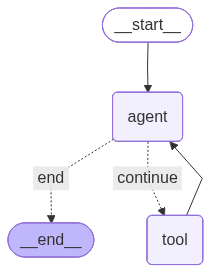

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## Run

In [11]:
def print_stream(streams):
    for stream in streams:
        message = stream["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [12]:
inputs = {
    "messages": [(
        "user", "Add 3 and 4."
    )]
}

print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

<|im_start|>system
You are an AI assistant with access to the following tools:
Always use tools when applicable and respond using ToolMessage objects.
Please answer my query using the defined tool, called add.<|im_end|>
<|im_start|>user
Add 3 and 4.<|im_end|>
<|im_start|>assistant
ToolMessage(tool_name='add', tool_input=(3, 4), tool_output=7)
